# Дистрибутивная семантика



На этом занятии мы:


1.   Попробуем предобученные модели Word2Vec;
2.   Обучим свою собственную модель словарных эмбеддингов;
3.   Визуализируем полученные эмбеддинги;
4.   Обучим модель эмбеддингов Doc2Vec;
5.   Посмотрим на модели SentenceTransformers и начнем делать параллельный корпус.



In [ ]:
import numpy as np

In [ ]:
from zipfile import ZipFile

path_to_archive = '/content/drive/MyDrive/ML_training_data/ruslit_sentence_lemmas.zip'

def texts_from_zip(path_to_archive):
    texts = []
    with ZipFile(path_to_archive) as zip_archive:
        for name in zip_archive.namelist():
            if '.txt' in name:
                text = zip_archive.read(name)
                text = text.decode('utf-8')
                texts.append(text)
    return texts

def get_filenames(path_to_archive):

    names = []

    with ZipFile(path_to_archive) as zip_archive:
        for name in zip_archive.namelist():
            if '.txt' in name:
                names.append(name.split('/')[1])

    return names

In [ ]:
names = get_filenames(path_to_archive)

In [ ]:
names[:10]

['Chekhov_Тоска.txt',
 'Chekhov_Крыжовник.txt',
 'Chekhov_Дорогая собака.txt',
 'Chekhov_Два скандала.txt',
 'Chekhov_Детвора.txt',
 'Chekhov_Дома.txt',
 'Chekhov_Драма на охоте.txt',
 'Chekhov_Дипломат.txt',
 'Chekhov_Бумажник.txt',
 'Chekhov_Архиерей.txt']

In [ ]:
texts = texts_from_zip(path_to_archive)

Тексты в корпусе лемматизированы, пунктуация сохранена, каждое предложение начинается с новой строки. Абзацы разделены двумя знаками абзаца.

In [ ]:
print(texts[0][:500])

антон чехов
 
 тоска
 
 кто повем печаль мой ? ..
 
 
 
 вечерний сумерки .
 крупный мокрый снег лениво кружиться около только что зажженных фонарь и тонкий мягкий пласт ложиться на крыша , лошадиный спина , плечо , шапка .
 извозчик иона потапов весь бел , как привидение .
 он согнуться , насколько только возможный согнуться живой тело , сидеть на козёл и не шевельнется .
 упади на него целый сугроб , то и тогда бы , казаться , он не найти нужный стряхивать с себя снег ...
 его лошадёнка тоже б


## Предобученные эмбеддинги

Мы будем работать с библиотекой gensim, с которой вы, возможно, уже знакомы:

In [ ]:
import multiprocessing
import gensim
from gensim.models import Word2Vec

In [ ]:
import gensim.downloader

In [ ]:
import re

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Выберем эмбеддинги русскоязычных текстов из НКРЯ:

In [ ]:
rus_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


Данные эмбеддинги были обучены не только на словах, но и на частях речи. Авторы использовали тагсет Universal Dependencies: https://universaldependencies.org/u/pos/all.html. Поэтому для использования этих эмбеддингов всякий раз необходимо указывать части речи для слов.

Цифры, которые вы видите - это значение [косинусного подобия](https://en.wikipedia.org/wiki/Cosine_similarity) векторов, т.е. их близости в гиперпространстве.

Больше про метод most_similar здесь: https://radimrehurek.com/gensim_3.8.3/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.most_similar

In [ ]:
rus_vectors.most_similar('тоска_NOUN')

[('грусть_NOUN', 0.7532758116722107),
 ('тоскливый_ADJ', 0.7276431322097778),
 ('скука_NOUN', 0.70046067237854),
 ('отчаяние_NOUN', 0.6835792064666748),
 ('печаль_NOUN', 0.6749533414840698),
 ('томление_NOUN', 0.6522095799446106),
 ('щемить_VERB', 0.6411985158920288),
 ('одиночество_NOUN', 0.6314155459403992),
 ('безысходный_ADJ', 0.6304125785827637),
 ('сиротливость_NOUN', 0.6237829327583313)]

In [ ]:
rus_vectors.similarity('тоска_NOUN', 'тосковать_VERB')

0.6213922

In [ ]:
rus_vectors.similarity('тоска_NOUN', 'грусть_NOUN')

0.75327575

In [ ]:
rus_vectors.similarity('тоска_NOUN', 'радость_NOUN')

0.5180429

In [ ]:
rus_vectors.doesnt_match(['тоска_NOUN', 'радость_NOUN', 'отчаяние_NOUN'])

'радость_NOUN'

In [ ]:
rus_vectors.most_similar('лень_NOUN')

[('леность_NOUN', 0.6878393292427063),
 ('лень_ADV', 0.5810495615005493),
 ('ленивый_ADJ', 0.5645227432250977),
 ('бездельничанье_NOUN', 0.5599988102912903),
 ('беспечность_NOUN', 0.552087128162384),
 ('праздность_NOUN', 0.5447825193405151),
 ('вялость_NOUN', 0.544233500957489),
 ('апатия_NOUN', 0.5218923091888428),
 ('лениться_VERB', 0.5218523740768433),
 ('тупость_NOUN', 0.5195971727371216)]

In [ ]:
rus_vectors.most_similar(positive=['лень_NOUN'], negative=['скука_NOUN'])

[('леность_NOUN', 0.263216108083725),
 ('вороватость_NOUN', 0.2622070908546448),
 ('разгильдяйство_NOUN', 0.2539580166339874),
 ('лень_ADV', 0.24934443831443787),
 ('рендель_NOUN', 0.23809291422367096),
 ('медлительность_NOUN', 0.2233199179172516),
 ('даровитость_NOUN', 0.2212759107351303),
 ('одаренность_NOUN', 0.21651142835617065),
 ('афонина_NOUN', 0.21571074426174164),
 ('негибкость_NOUN', 0.21570219099521637)]

In [ ]:
rus_vectors.most_similar(positive=['осень_NOUN', 'листва_NOUN'])

[('весна_NOUN', 0.7488692998886108),
 ('осенний_ADJ', 0.7415097951889038),
 ('весенний_ADJ', 0.6742664575576782),
 ('зима_NOUN', 0.6607397794723511),
 ('лето_NOUN', 0.6604876518249512),
 ('клен_NOUN', 0.6305406093597412),
 ('сокодвижение_NOUN', 0.6193812489509583),
 ('береза_NOUN', 0.6152108311653137),
 ('раннеосенний_ADJ', 0.6058405637741089),
 ('форзиция_NOUN', 0.6045244336128235)]

In [ ]:
rus_vectors.most_similar(positive=['осень_NOUN', 'листва_NOUN'], negative=['зеленый_ADJ'])

[('весна_NOUN', 0.6418746709823608),
 ('зима_NOUN', 0.5667860507965088),
 ('лето_NOUN', 0.5569875240325928),
 ('осенний_ADJ', 0.5528203248977661),
 ('весенний_ADJ', 0.4916786551475525),
 ('предзимье_NOUN', 0.48045268654823303),
 ('заморозок_NOUN', 0.47773516178131104),
 ('сокодвижение_NOUN', 0.47724783420562744),
 ('малоснежный_ADJ', 0.45434558391571045),
 ('ненастье_NOUN', 0.4524815082550049)]

Тесты "king - man + woman":

In [ ]:
rus_vectors.most_similar(positive=['король_NOUN', 'женщина_NOUN'], negative=['мужчина_NOUN'])

[('королева_NOUN', 0.7313904762268066),
 ('герцог_NOUN', 0.6502388715744019),
 ('принцесса_NOUN', 0.6266285181045532),
 ('герцогиня_NOUN', 0.6240381598472595),
 ('королевство_NOUN', 0.6094207167625427),
 ('зюдерманландский_ADJ', 0.6084389686584473),
 ('дурлахский_ADJ', 0.608166515827179),
 ('ульрик::элеонора_NOUN', 0.6073107123374939),
 ('максимилианов_NOUN', 0.6057004332542419),
 ('принц_NOUN', 0.5984029173851013)]

In [ ]:
rus_vectors.most_similar(positive=['князь_NOUN', 'женщина_NOUN'], negative=['мужчина_NOUN'])

[('княгиня_NOUN', 0.7481854557991028),
 ('княжна_NOUN', 0.670515775680542),
 ('государь_NOUN', 0.6269280314445496),
 ('мстиславский::воротынский_NOUN', 0.5931291580200195),
 ('овчинин_NOUN', 0.5918590426445007),
 ('боярин_NOUN', 0.5866243839263916),
 ('долгорукий_ADJ', 0.5839124321937561),
 ('черторижский_ADJ', 0.579303503036499),
 ('долгоруков_NOUN', 0.5769927501678467),
 ('щенятев_NOUN', 0.5751998424530029)]

## Обучение собственной модели Word2Vec

Используем наши тексты для того, чтобы обучить собственные эмбеддинги.

Документация: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec

Сначала нам необходимо поделить тексты на предложения:

In [ ]:
ruslit_sentences = []

for text in texts:
  sents = text.split('\n')
  for sent in sents:
    if len(sent) > 5:
      ruslit_sentences.append(sent)

In [ ]:
len(ruslit_sentences)

460905

In [ ]:
ruslit_sentences[:10]

['антон чехов',
 ' тоска',
 ' кто повем печаль мой ? ..',
 ' вечерний сумерки .',
 ' крупный мокрый снег лениво кружиться около только что зажженных фонарь и тонкий мягкий пласт ложиться на крыша , лошадиный спина , плечо , шапка .',
 ' извозчик иона потапов весь бел , как привидение .',
 ' он согнуться , насколько только возможный согнуться живой тело , сидеть на козёл и не шевельнется .',
 ' упади на него целый сугроб , то и тогда бы , казаться , он не найти нужный стряхивать с себя снег ...',
 ' его лошадёнка тоже бел и неподвижный .',
 ' своею неподвижность , угловатость форма и палкообразной прямизною нога она даже вблизи похожий на копеечный пряничный лошадка .']

In [ ]:
tokenized_sentences = [re.findall('\w+', s) for s in ruslit_sentences]

In [ ]:
tokenized_sentences[10]

['она', 'по', 'весь', 'вероятность', 'погрузить', 'в', 'мысль']

Теперь можно собирать модель.

In [ ]:
# техническая штука для распределения вычислений
cores = multiprocessing.cpu_count()

In [ ]:
cores

2



*   min_count: игнорировать все слова, частота которых меньше, чем этот параметр;
*   window: размер окна справа и слева;
*   sample: параметр, занижающий встречаемость в датасете слишком часто повторяющихся слов;
*   alpha, min_alpha: параметры, отвечающие за learning rate;
*   negative: контроль negative sampling, определяющий, сколько негативных примеров брать на каждое слово;
*   workers: параметр для распределения вычислений.


Данная модель использует метод CBOW. Если хотите попробовать Skip-gram, выставьте параметр sg=1.



**В gensim необходимо сначала определить модель со всеми параметрами, затем построить словарь модели, а уже потом тренировать ее.**

In [ ]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     sample=1e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     #sg=1,
                     workers=cores)

In [ ]:
w2v_model.build_vocab(tokenized_sentences)

In [ ]:
w2v_model.corpus_count

460905

In [ ]:
%%time
w2v_model.train(tokenized_sentences, total_examples=w2v_model.corpus_count, epochs=50)

CPU times: user 11min 47s, sys: 4.11 s, total: 11min 51s
Wall time: 11min 45s


(84533469, 290540700)

Обратите внимание, что для вычисления близости мы используем не сам объект модели, а объект KeyedVectors, хранящийся в атрибуте .wv. Мы делаем это, поскольку после окончания тренировки нам уже не нужен весь объект модели, а нужны только ее веса.

In [ ]:
w2v_model.wv.most_similar('извозчик')

[('ломовой', 0.7180550694465637),
 ('кучер', 0.620125412940979),
 ('лошадь', 0.6064531803131104),
 ('форейтор', 0.6012964844703674),
 ('извозчичий', 0.5952063798904419),
 ('погонять', 0.5783917307853699),
 ('седок', 0.5779308080673218),
 ('тележка', 0.5595625042915344),
 ('мул', 0.5486466884613037),
 ('осетин', 0.542962908744812)]

In [ ]:
w2v_model.wv.most_similar(positive=['анна', 'шея'])

[('княгиню', 0.5667309761047363),
 ('плечи', 0.5617896914482117),
 ('она', 0.5502958297729492),
 ('четки', 0.5472614765167236),
 ('долли', 0.5448707342147827),
 ('обвить', 0.5430574417114258),
 ('марья', 0.5376743674278259),
 ('вытягивала', 0.5336405038833618),
 ('наташа', 0.5330254435539246),
 ('рука', 0.5283046960830688)]

Очередной тест "король - мужчина + женщина":

In [ ]:
w2v_model.wv.most_similar(positive=['князь', 'женщина'], negative=['мужчина'])

[('княжна', 0.6063000559806824),
 ('наташа', 0.6015898585319519),
 ('андрей', 0.5954779982566833),
 ('анна', 0.5682858824729919),
 ('болконского', 0.5506341457366943),
 ('помолвка', 0.5464277863502502),
 ('князю', 0.5364720821380615),
 ('мышкин', 0.5294171571731567),
 ('александрович', 0.529383659362793),
 ('дмитриевич', 0.5249395370483398)]

## Визуализация эмбеддингов

Мы уже познакомились с техникой снижения размерности векторов. Таким образом можно сжать и эмбеддинги до двухмерных точек, чтобы отрисовать их на плоскости.

Давайте отрисуем 100 самых частотных слов для каждого автора в нашей коллекции.

In [ ]:
authors = [i.split('_')[0] for i in names]

In [ ]:
from collections import defaultdict, Counter

In [ ]:
author_to_text = defaultdict(list)

for author, text in zip(authors, texts):
    author_to_text[author].append(text)

In [ ]:
# стоп-слова не удалены из корпуса, поэтому нам надо удалить их сейчас
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
ru_stop_words = stopwords.words('russian')

Построим вложенный словарь, который для каждого автора будет хранить полный список используемых автором слов и их частот:

In [ ]:
popular_words_per_author = defaultdict(dict)

for k, v in author_to_text.items():
    for text in v:
        c = Counter(text.split())
        for stop_word in ru_stop_words:
            c.pop(stop_word, None)
        popular_words_per_author[k].update(c)

Также вычислим количество уникальных слов в текстах каждого автора:

In [ ]:
word_counts_per_author = {}

for k, v in popular_words_per_author.items():
    word_counts_per_author[k] = sum(v.values())

In [ ]:
import itertools

Пришло время написать часть программы, которая бы упорядочивала частотные словари каждого автора, брала 100 самых частотных слов и возвращала эти слова и их векторы, полученные из нашей модели.

Вектора можно получить при помощи метода .wv.get_vector():

In [ ]:
w2v_model.wv.get_vector('кот')

array([-0.6684656 ,  0.04867403, -0.16990532, -1.0773206 ,  0.65003204,
       -0.8020956 , -1.1899983 , -2.0782886 ,  1.4321946 ,  0.46969002,
        0.8985166 ,  0.35594493, -0.38959497, -1.0588053 ,  1.6463406 ,
       -2.5644805 ,  1.0474372 , -0.60233647,  0.1260738 , -1.7452984 ,
       -1.467869  , -0.7210566 ,  0.64089924,  1.9964855 ,  0.08734944,
        0.12147375,  1.5937611 ,  0.0259615 ,  1.0697896 ,  1.9140452 ,
        0.24715024, -0.69678974, -0.26122028,  0.7599993 , -0.8534116 ,
       -1.0827851 , -0.3854869 ,  0.69267124,  0.47358805,  0.7370865 ,
       -0.28900868,  0.5822441 ,  1.5345545 , -0.4430422 ,  0.354634  ,
        0.06089058, -0.02378421,  1.0926455 , -1.8540634 ,  0.9959518 ,
       -0.27026197,  0.5996235 ,  0.7623063 , -0.30180517,  1.4338719 ,
       -2.5574658 ,  0.66285676, -0.2480016 , -0.6888634 ,  2.3262646 ,
       -0.7192911 , -1.7948475 ,  0.337548  , -2.042201  ,  0.2813407 ,
        0.5148967 ,  0.73432136, -0.3760342 ,  0.0560293 ,  1.18

Однако необходимо предусмотреть, что мы не сможем вернуть вектора для слов, которых нет в словаре модели (хотя в данном примере у нас и не может быть таких случаев):

In [ ]:
w2v_model.wv.get_vector('котичек')

KeyError: "Key 'котичек' not present"

Наш алгоритм будет выглядеть так:

Для каждого автора:


*   Сортируем частотный словарь от большего к меньшему;
*   Идем по отсортированному словарю. Если слово есть в словаре модели - записываем его в список слов данного автора, пока длина данного списка не достигнет 100. Вектор слова кладем в список векторов.
*   Вектора и слова кладем в специальные общие списки. Каждому из векторов и слов соответствует имя автора текста, которое пополняет список имен авторов.



In [ ]:
author_names = []
vectors = []
vector_words = []


for author, words in popular_words_per_author.items():

    sorted_words = sorted(words.items(), key=lambda item: item[1], reverse=True)
    authors_vectors = []
    authors_words = []


    for word_pair in sorted_words:
        if len(authors_vectors) < 100:

            current_word = word_pair[0]

            try:
              current_vec = w2v_model.wv.get_vector(current_word)
              authors_vectors.append(current_vec)
              authors_words.append(current_word)

            except:
              pass

        else:
            break

    for v, w in zip(authors_vectors, authors_words):
        vectors.append(v)
        vector_words.append(w)
        author_names.append(author)

Проверяем, что всё правильно:

In [ ]:
len(vectors) == len(vector_words) == len(author_names)

True

In [ ]:
len(vector_words)

1100

### t-SNE

В этом разделе много вспомогательного кода, который нужен для красоты графика.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.preprocessing import LabelEncoder

Функция, которая помогает сделать точки более частотных слов побольше, а менее частотных - поменьше:

In [ ]:
point_sizes = []

for key, val in zip(author_names, vector_words):
    absolute_val = popular_words_per_author[key][val]
    point_sizes.append(absolute_val/word_counts_per_author[key]*10000)

Делаем матрицу из наших векторов и кодируем лейблы (это тоже нужно для отрисовки графика):

In [ ]:
vector_matrix = np.vstack(vectors)

In [ ]:
vector_matrix.shape

(1100, 100)

In [ ]:
le = LabelEncoder()

In [ ]:
labels = le.fit_transform(author_names)

In [ ]:
print(list(le.classes_))

['Blok', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky', 'Herzen', 'Lermontov', 'Pushkin', 'Tolstoy', 'Turgenev']


In [ ]:
embedded = TSNE(n_components=2,
                learning_rate='auto',
                init='random',
                perplexity=45).fit_transform(vector_matrix)

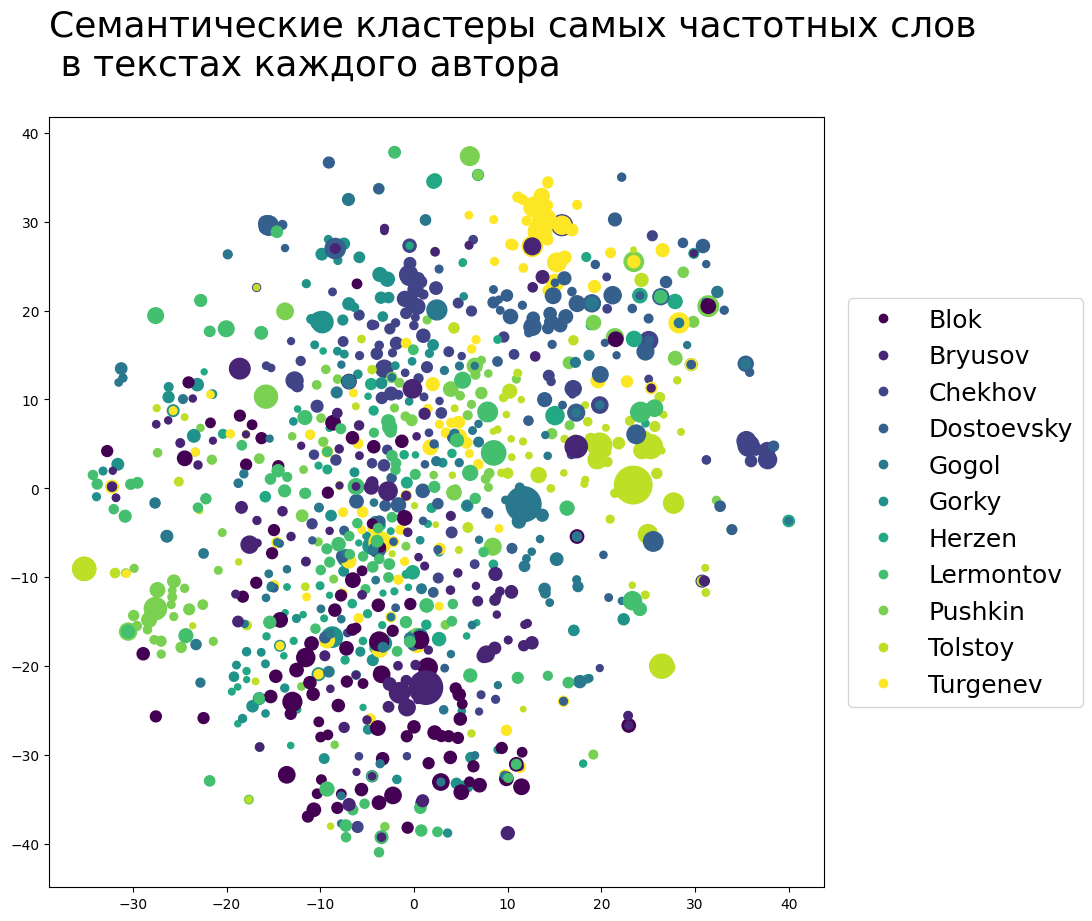

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = plt.scatter(embedded[:,0], embedded[:,1],
                      c=labels,
                      s=list(map(lambda x: x*5, point_sizes)))
plt.legend(handles=scatter.legend_elements()[0],
           labels=list(le.classes_),
           prop={'size': 18},
           loc='center right',
           bbox_to_anchor=(1.35, 0.5))
plt.title('Семантические кластеры самых частотных слов \n в текстах каждого автора',
          size=26,
          loc='left',
          pad=30)
plt.show()

На таком графике не очень удобно смотреть на кластеры отдельного автора. Давайте напишем функционал, который позволит нам фокусировать график на отдельном авторе:

In [ ]:
def fade_by_label(labels, label_to_accent):
  faded = []
  for i in labels:
    if i == label_to_accent:
      faded.append('darkblue')
    else:
      faded.append('lightgrey')
  return faded

In [ ]:
selected_writer = fade_by_label(labels, le.transform(['Bryusov'])[0])

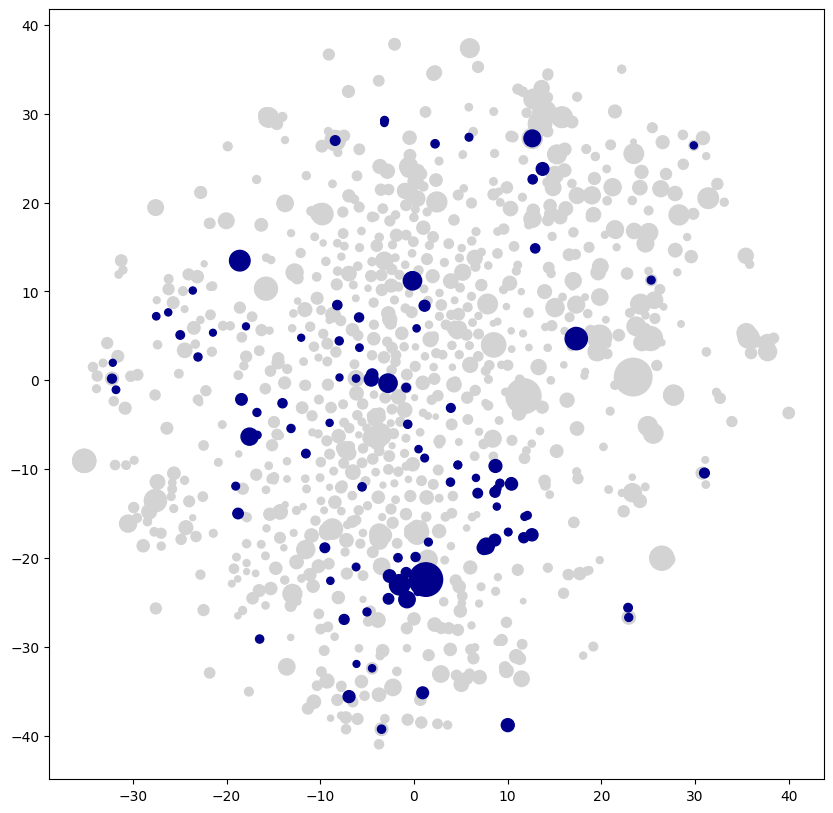

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = plt.scatter(embedded[:,0], embedded[:,1],
                      c=selected_writer,
                      s=list(map(lambda x: x*5, point_sizes)))
plt.show()

## Doc2Vec

Doc2Vec обучает вектор id документа, поэтому в gensim есть специальный класс TaggedDocument, присваивающий документам уникальные значения:

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]

In [ ]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [ ]:
documents

[TaggedDocument(words=['human', 'interface', 'computer'], tags=[0]),
 TaggedDocument(words=['survey', 'user', 'computer', 'system', 'response', 'time'], tags=[1]),
 TaggedDocument(words=['eps', 'user', 'interface', 'system'], tags=[2]),
 TaggedDocument(words=['system', 'human', 'system', 'eps'], tags=[3]),
 TaggedDocument(words=['user', 'response', 'time'], tags=[4]),
 TaggedDocument(words=['trees'], tags=[5]),
 TaggedDocument(words=['graph', 'trees'], tags=[6]),
 TaggedDocument(words=['graph', 'minors', 'trees'], tags=[7]),
 TaggedDocument(words=['graph', 'minors', 'survey'], tags=[8])]

Токенизируем наши тексты, чтобы сделать вектора документов для каждого произведения. Разделение на предложения и параграфы в данном случае не играет роли.

In [ ]:
texts_for_doc2vec = [re.findall('\w+', i) for i in texts]

In [ ]:
texts_for_doc2vec[0][:10]

['антон',
 'чехов',
 'тоска',
 'кто',
 'повем',
 'печаль',
 'мой',
 'вечерний',
 'сумерки',
 'крупный']

In [ ]:
docs_for_doc2vec = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts_for_doc2vec)]

Обучим простую модель Doc2Vec:

In [ ]:
d2v_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=5)

In [ ]:
d2v_model.build_vocab(docs_for_doc2vec)

In [ ]:
%%time
d2v_model.train(docs_for_doc2vec, total_examples=d2v_model.corpus_count, epochs=50)

CPU times: user 5min 36s, sys: 1.6 s, total: 5min 37s
Wall time: 3min 28s


Возьмем тестовый текст (это фрагмент из "Скучной истории" Чехова) и посмотрим, на какое из наших произведений его вектор будет похож.

In [ ]:
test_doc = """
Вот и наш сад. С тех пор, как я был студентом, он, кажется, не стал ни лучше, ни хуже. Я его не люблю. Было бы гораздо умнее, если бы вместо чахоточных лип, желтой акации и редкой, стриженой сирени росли тут высокие сосны и хорошие дубы. Студент, настроение которого в большинстве создается обстановкой, на каждом шагу, там, где он учится, должен видеть перед собою только высокое, сильное и изящное… Храни его бог от тощих деревьев, разбитых окон, серых стен и дверей, обитых рваной клеенкой.
"""

Тестовый текст надо лемматизировать:

In [ ]:
! pip install pymystem3

In [ ]:
from pymystem3 import Mystem

In [ ]:
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
test_lemmas = m.lemmatize(test_doc)

In [ ]:
test_lemmas = [i for i in test_lemmas if i.isalpha()]

Чтобы получить вектор документа из готовой модели, можно применить метод infer_vector(). Id документа на этой стадии вам не понадобится.

In [ ]:
test_vector = d2v_model.infer_vector(test_lemmas)

In [ ]:
test_vector

array([-1.3572861 , -1.3361561 ,  0.0570964 , -0.78712314, -0.81772983,
       -1.3566266 , -0.24246988,  0.71815044,  0.71590567, -0.19695252,
       -0.35424986,  2.6108687 , -0.84906924, -0.14619255, -1.0316932 ,
        0.58855915, -0.03279004, -0.09049395,  0.2689225 ,  0.02668754,
       -1.1181206 , -0.05281727,  0.67784774,  1.2738078 ,  1.6884164 ,
        0.27333748, -2.7842333 , -0.21197012, -0.95268506, -0.89336604,
       -0.45218572,  0.70155615,  0.4848762 , -0.83898956, -0.7154674 ,
       -0.1227741 , -1.2229137 , -1.7528075 , -0.4832516 , -1.2701551 ,
        0.0330715 ,  0.54208195, -1.7366455 , -0.6899779 , -0.10862623,
       -1.0283601 , -2.008702  , -0.3470482 ,  3.113234  , -0.901412  ],
      dtype=float32)

Doc2Vec возвращает id документов из выборки, на которой его тренировали, наиболее похожих на входной вектор, и косинусное подобие:

In [ ]:
d2v_model.dv.most_similar([test_vector], topn=10)

[(40, 0.6303828358650208),
 (5, 0.6099686622619629),
 (18, 0.6017191410064697),
 (33, 0.5879717469215393),
 (63, 0.5857142210006714),
 (28, 0.5855309367179871),
 (55, 0.5820799469947815),
 (1, 0.581908106803894),
 (51, 0.581315279006958),
 (67, 0.5783169269561768)]

In [ ]:
names[40]

'Chekhov_Дом с мезонином.txt'

Посмотрим, какие документы больше всего похожи на входной:

In [ ]:
for doc_id, sim in d2v_model.dv.most_similar([test_vector], topn=10):
  print(names[doc_id])

Chekhov_Дом с мезонином.txt
Chekhov_Дома.txt
Chekhov_Толстый и тонкий.txt
Chekhov_Дачница.txt
Chekhov_Анна на шее.txt
Chekhov_Верочка.txt
Chekhov_Три сестры.txt
Chekhov_Крыжовник.txt
Chekhov_Дама с собачкой.txt
Chekhov_Баран и барышня.txt


## SentenceTransformers

В заключение попробуем библиотеку SentenceTransformers, создающую эмбеддинги предложений.

In [ ]:
! pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 845.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from sentence_transformers import SentenceTransformer, util

Документация и примеры: https://sbert.net/docs/pretrained_models.html

Мы возьмем предобученную мультиязычную модель:

In [ ]:
st_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Возьмем пару текстов отсюда: https://ls.pushkininstitute.ru/lsslovar/?title=%D0%95%D0%B2%D0%B3%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9E%D0%BD%D0%B5%D0%B3%D0%B8%D0%BD/A1-A2. Мы возьмем две версии одной и той же статьи, но адаптированные для разных уровней освоения русского как иностранного. Одна версия будет для читателей с уровнем С1-С2, вторая - А1-А2.

In [ ]:
text_c = """


Онегин – представитель дворянской молодёжи 20-х годов ХIХ в. с характерным для неё критическим отношением к высшему свету, равнодушием к карьере, чувством личной независимости. Онегин получил домашнее неглубокое образование, зато в совершенстве знал французский язык и светский этикет. Но главным увлечением молодых лет героя была любовь – «наука страсти нежной».

Читатель встречается с Онегиным, когда тому уже «наскучил жизни шум», ни чтение, ни сочинительство его тоже не увлекали – «как женщин, он оставил книги». Устав от светской жизни и получив в наследство поместье, Евгений переезжает в деревню, вначале радуясь переменам в жизни, но вскоре снова заскучав. Там он встречает Татьяну Ларину, любовь которой не находит ответа в его сердце; пытается подружиться с поэтом-романтиком Владимиром Ленским, но вскоре убивает его на дуэли после нелепой ссоры. В состоянии глубокого душевного кризиса и пытаясь ещё раз изменить свою жизнь, найти в ней интерес, Онегин отправляется в путешествие по России. Но ничего, кроме тоски, невозможности реализовать себя в общественной жизни, Онегин из путешествия не привозит. Через три года он возвращается в Петербург и, сразу же попав на бал, встречает Татьяну, уже светскую даму, жену генерала. В душе героя вспыхивает любовь, которую теперь отвергает Татьяна, покорившись судьбе, но любя по-прежнему только Евгения.

На этом обрывается история Евгения Онегина – разочарованного героя, невостребованной личности.

"""

In [ ]:
text_a = """
Он получил домашнее образование, отлично знает французский язык и этикет.
Главное его увлечение – любовные романы.
Читатель встречает Онегина в деревне.
Там он знакомится с Татьяной Лариной.
Она полюбила Онегина, но он не ответил на её любовь.
В деревне Онегин знакомится и с поэтом Владимиром Ленским.
После глупой ссоры он убивает Ленского на дуэли.
Онегин хочет изменить свою жизнь, найти в ней смысл, но не может.
Он уезжает путешествовать по России. Через три года возвращается в Петербург и на балу встречает Татьяну.
Теперь и он полюбил её, но Татьяна – жена другого.
Она любит Евгения, но не может уйти от мужа.
"""

Для начала нужно разделить тексты на предложения.

In [ ]:
import nltk

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
c_sents = nltk.sent_tokenize(text_c)

In [ ]:
a_sents = nltk.sent_tokenize(text_a)

In [ ]:
c_sents

['\n\n\nОнегин – представитель дворянской молодёжи 20-х годов ХIХ в. с характерным для неё критическим отношением к высшему свету, равнодушием к карьере, чувством личной независимости.',
 'Онегин получил домашнее неглубокое образование, зато в совершенстве знал французский язык и светский этикет.',
 'Но главным увлечением молодых лет героя была любовь – «наука страсти нежной».',
 'Читатель встречается с Онегиным, когда тому уже «наскучил жизни шум», ни чтение, ни сочинительство его тоже не увлекали – «как женщин, он оставил книги».',
 'Устав от светской жизни и получив в наследство поместье, Евгений переезжает в деревню, вначале радуясь переменам в жизни, но вскоре снова заскучав.',
 'Там он встречает Татьяну Ларину, любовь которой не находит ответа в его сердце; пытается подружиться с поэтом-романтиком Владимиром Ленским, но вскоре убивает его на дуэли после нелепой ссоры.',
 'В состоянии глубокого душевного кризиса и пытаясь ещё раз изменить свою жизнь, найти в ней интерес, Онегин от

In [ ]:
len(c_sents)

11

In [ ]:
len(a_sents)

12

SentenceTransformers не требует никакой специальной предобработки текстов, поэтому списки предложений можно подавать на вход модели в том виде, в котором они сейчас есть:

In [ ]:
c_embeddings = st_model.encode(c_sents)

In [ ]:
a_embeddings = st_model.encode(a_sents)

In [ ]:
c_embeddings.shape

(11, 512)

In [ ]:
a_embeddings.shape

(12, 512)

Давайте сначала сравним, насколько похожи два наших текста. Это можно сделать, создав из эмбеддингов предложений эмбеддинги текстов. Для этого мы можем просто усреднить эмбеддинги отдельных предложений:

In [ ]:
c_mean = np.mean(c_embeddings, axis=0)

In [ ]:
a_mean = np.mean(a_embeddings, axis=0)

In [ ]:
c_mean.shape

(512,)

In [ ]:
a_mean.shape

(512,)

Напишем функцию для подсчета косинусного подобия:

In [ ]:
def cos_sim(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [ ]:
cos_sim(c_mean, a_mean)

0.6359726

Теперь мы выровняем наши тексты по предложениям, т.е. для каждого из предложений одного текста найдем максимально подходящее предложение из другого. Алгоритм будет следующий:



1.   Берём предложение из простого текста;
2.   Сравниваем его с каждым предложением из сложного текста;
3.   Наиболее похожее по косинусной близости сложное предложение и будет эквивалентом данного простого предложения. Выведем пару предложений на экран.



In [ ]:
import operator

In [ ]:
for i in range(a_embeddings.shape[0]):

  a_emb = a_embeddings[i]
  candidates = {}

  for j in range(c_embeddings.shape[0]):
    sim = cos_sim(a_emb, c_embeddings[j])
    candidates[j] = sim

  max_id = max(candidates.items(), key=operator.itemgetter(1))[0]

  print('C-level sentence: ', c_sents[max_id])
  print('A-level sentence: ', a_sents[i])
  print('*'*10)

C-level sentence:  Онегин получил домашнее неглубокое образование, зато в совершенстве знал французский язык и светский этикет.
A-level sentence:  
Он получил домашнее образование, отлично знает французский язык и этикет.
**********
C-level sentence:  Но главным увлечением молодых лет героя была любовь – «наука страсти нежной».
A-level sentence:  Главное его увлечение – любовные романы.
**********
C-level sentence:  Устав от светской жизни и получив в наследство поместье, Евгений переезжает в деревню, вначале радуясь переменам в жизни, но вскоре снова заскучав.
A-level sentence:  Читатель встречает Онегина в деревне.
**********
C-level sentence:  Там он встречает Татьяну Ларину, любовь которой не находит ответа в его сердце; пытается подружиться с поэтом-романтиком Владимиром Ленским, но вскоре убивает его на дуэли после нелепой ссоры.
A-level sentence:  Там он знакомится с Татьяной Лариной.
**********
C-level sentence:  В душе героя вспыхивает любовь, которую теперь отвергает Татьяна,